In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import mlxtend.frequent_patterns 
import mlxtend.preprocessing

### Data Exploration

In [3]:
transactions = pd.read_excel('QVI_transaction_data.xlsx')

In [4]:
purchases = pd.read_csv('QVI_purchase_behaviour.csv')

In [5]:
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
purchases.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [8]:
transactions.DATE = pd.to_datetime(transactions.DATE, origin = '1899-12-30', unit='D')

In [9]:
transactions.PROD_NAME.unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [10]:
# remove digit 'Replace all occurring digits in the strings with nothing'.
transactions['product_name'] = transactions.PROD_NAME.str.replace('\d+', '')

# remove special characters 'doesn't remove white space
transactions['product_name'] = transactions.product_name.str.replace('[^\w\s]', '')

# remove extra spaces between wrods
transactions['product_name'] = transactions.product_name.str.replace('\s+', ' ')

# remove the leftover 2 characters ' g'
transactions['product_name'] = transactions.product_name.str.rstrip(' g')

In [11]:
# count word frequency
product_name_ValueCount = transactions.product_name.str.split(expand=True).stack().value_counts()

In [12]:
product_name_ValueCount[:50]

Chips         49770
Kettle        41288
Smiths        28860
Salt          27976
Cheese        27890
Pringles      25102
Doritos       24962
Crinkle       23960
Corn          22063
Original      21560
Cut           20754
Chip          18645
Chicken       18577
Salsa         18094
Sea           14145
Thins         14075
Chilli        13895
Sour          13882
Crisps        12607
Vinegar       12402
RRD           11894
Infuzions     11057
Supreme       10963
WW            10320
Popd           9693
Cobs           9693
Tortilla       9580
Tostitos       9471
Twisties       9454
Sensations     9429
Old            9324
Dip            9324
Paso           9324
El             9324
Sweet          7883
Lime           7852
Chives         7846
Tomato         7669
Cream          7618
Thinly         7507
Tyrrells       6442
And            6373
BBQ            6351
Tangy          6332
Waves          6272
Grain          6272
Salted         6248
Lightly        6248
Soy            6121
Natural        6050


In [13]:
# remove salsa products
chips_transaction = transactions[transactions['product_name'].str.contains('Salsa')==False]
chips_transaction.drop(axis=1, columns='PROD_NAME', inplace=True)

In [14]:
# check statistics
chips_transaction.describe()
# PROD_QTY and TOT_SALES have outliers (max)

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


<AxesSubplot:>

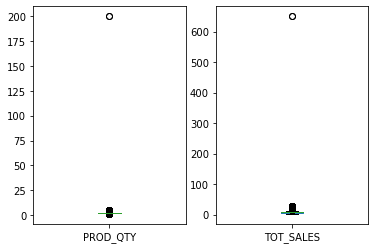

In [15]:
# check outliers
fig, axes = plt.subplots(1, 2)
chips_transaction.PROD_QTY.plot.box(ax=axes[0])
chips_transaction.TOT_SALES.plot.box(ax=axes[1])

In [16]:
# remove outliers
chips_transaction.drop(chips_transaction[chips_transaction.PROD_QTY>=200].index, inplace=True)

In [17]:
# check NA values
chips_transaction.isna().sum()
# -> no NA values

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_QTY          0
TOT_SALES         0
product_name      0
dtype: int64

In [18]:
# check transactions per date, see if any date is missing
print('Total No.days: ', len(chips_transaction.DATE.unique()))
print('Start day: ', chips_transaction.DATE.dt.date.min())
print('End day: ', chips_transaction.DATE.dt.date.max())
print('No.days between Start and End: ', chips_transaction.DATE.dt.date.max() - chips_transaction.DATE.dt.date.min())
# -> 1 day missing

Total No.days:  364
Start day:  2018-07-01
End day:  2019-06-30
No.days between Start and End:  364 days, 0:00:00


In [19]:
chips_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            246740 non-null  datetime64[ns]
 1   STORE_NBR       246740 non-null  int64         
 2   LYLTY_CARD_NBR  246740 non-null  int64         
 3   TXN_ID          246740 non-null  int64         
 4   PROD_NBR        246740 non-null  int64         
 5   PROD_QTY        246740 non-null  int64         
 6   TOT_SALES       246740 non-null  float64       
 7   product_name    246740 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 16.9+ MB


In [20]:
day_transaction = chips_transaction.groupby(chips_transaction.DATE).count()

In [21]:
missing_date = pd.date_range(day_transaction.index.min(), day_transaction.index.max()).difference(day_transaction.index)

In [22]:
day_transaction.loc[missing_date[0],:] = [0,0,0,0,0,0,0]

In [23]:
day_transaction.sort_index()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,product_name
DATE,,,,,,,
2018-07-01,663.0,663.0,663.0,663.0,663.0,663.0,663.0
2018-07-02,650.0,650.0,650.0,650.0,650.0,650.0,650.0
2018-07-03,674.0,674.0,674.0,674.0,674.0,674.0,674.0
2018-07-04,669.0,669.0,669.0,669.0,669.0,669.0,669.0
2018-07-05,660.0,660.0,660.0,660.0,660.0,660.0,660.0
...,...,...,...,...,...,...,...
2019-06-26,657.0,657.0,657.0,657.0,657.0,657.0,657.0
2019-06-27,669.0,669.0,669.0,669.0,669.0,669.0,669.0
2019-06-28,673.0,673.0,673.0,673.0,673.0,673.0,673.0


<AxesSubplot:xlabel='DATE'>

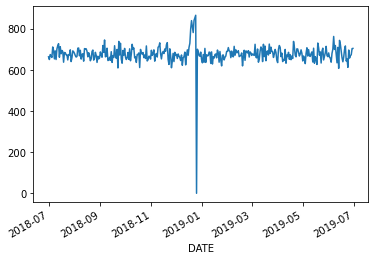

In [24]:
day_transaction.TOT_SALES.plot()
# there is a big increase in Dec 2018

<AxesSubplot:xlabel='DATE'>

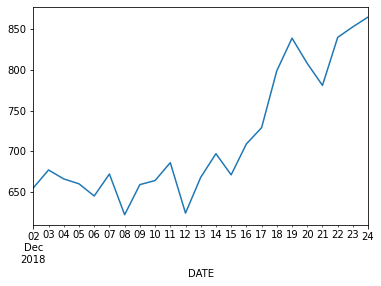

In [25]:
day_transaction.TOT_SALES[(day_transaction.index > '2018-12-01') & (day_transaction.index < '2018-12-25')].plot()
# the increase is due to christmas, and there is no sales on the christmas day because shops are closed.

In [26]:
# extract package size from PROD_NAME
transactions['pack_size'] = transactions.PROD_NAME.str.extract('(\d+)')
transactions['pack_size'] = transactions['pack_size'].astype('int')

In [27]:
transactions.pack_size.sort_values()

81754      70
87947      70
87945      70
87929      70
175102     70
         ... 
95648     380
233724    380
187018    380
95613     380
80022     380
Name: pack_size, Length: 264836, dtype: int32

In [28]:
bins = len(transactions.pack_size.unique())

<AxesSubplot:ylabel='Frequency'>

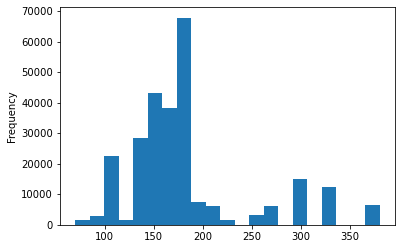

In [29]:
# plot No. transactions by pack size
transactions.pack_size.plot.hist(bins=bins)

In [30]:
transactions['brand'] = transactions['PROD_NAME'].str.split(' ').str[0]

In [31]:
transactions.brand.unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

In [32]:
# clean brand names (same brands with different names)
transactions.brand = transactions.brand.replace({'Red':'RRD', 'Smith': 'Smiths', 'Snbts': 'Sunbites'})

In [33]:
transactions.brand.unique().size

26

In [34]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Customer by Lifestage')

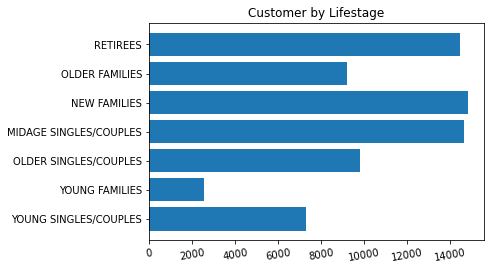

In [35]:
index = purchases.LIFESTAGE.unique()
y = purchases.LYLTY_CARD_NBR.groupby(purchases.LIFESTAGE).count()
plt.barh(y=index, width=y)
plt.xticks(rotation=10)
plt.title('Customer by Lifestage')

Text(0.5, 1.0, 'Customer by Membership')

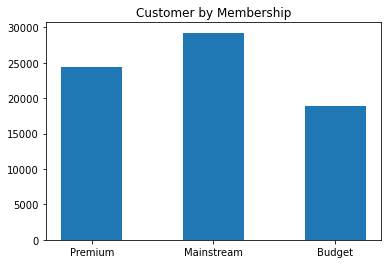

In [36]:
index = purchases.PREMIUM_CUSTOMER.unique()
y = purchases.LYLTY_CARD_NBR.groupby(purchases.PREMIUM_CUSTOMER).count()
plt.bar(x=index, height=y, width=0.5)
plt.title('Customer by Membership')

In [37]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
 8   product_name    264836 non-null  object        
 9   pack_size       264836 non-null  int32         
 10  brand           264836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(3)
memory usage: 21.2+ MB


In [38]:
# merge transaction data with customer data
data_merge = pd.merge(transactions, purchases, how='left', on='LYLTY_CARD_NBR')

In [39]:
# merge chip_transaction data with customer data
chips_data_merge = pd.merge(chips_transaction, purchases, how='left', on='LYLTY_CARD_NBR')

In [40]:
print('transaction shape: ', transactions.shape)
print('data_merge shape: ', data_merge.shape)
print('chips_transaction shape: ', chips_transaction.shape)
print('chips_data_merge shape: ', chips_data_merge.shape)

transaction shape:  (264836, 11)
data_merge shape:  (264836, 13)
chips_transaction shape:  (246740, 8)
chips_data_merge shape:  (246740, 10)


In [41]:
# check if any customer is not matched on
data_merge.isna().sum()
# -> everyone has a match

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
product_name        0
pack_size           0
brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [317]:
data_merge.to_csv('QVI_data.csv')

In [328]:
chips_data_merge.to_csv('QVI_chips.csv')

### Data Analysis on customer segments

#### who spends the most on chips (total sales):

In [2]:
chips_data_merge = pd.read_csv('QVI_chips.csv')

In [3]:
chips_data_merge.head()

,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,product_name,LIFESTAGE,PREMIUM_CUSTOMER
0,0,2018-10-17,1,1000,1,5,2,6.0,Natural Chip Compny SeaSalt,YOUNG SINGLES/COUPLES,Premium
1,1,2019-05-14,1,1307,348,66,3,6.3,CCs Nacho Cheese,MIDAGE SINGLES/COUPLES,Budget
2,2,2019-05-20,1,1343,383,61,2,2.9,Smiths Crinkle Cut Chips Chicken,MIDAGE SINGLES/COUPLES,Budget
3,3,2018-08-17,2,2373,974,69,5,15.0,Smiths Chip Thinly SCreamOnion,MIDAGE SINGLES/COUPLES,Budget
4,4,2018-08-18,2,2426,1038,108,3,13.8,Kettle Tortilla ChpsHnyJlpno Chili,MIDAGE SINGLES/COUPLES,Budget


In [44]:
total_sale_summary = chips_data_merge.TOT_SALES.groupby([chips_data_merge.PREMIUM_CUSTOMER, chips_data_merge.LIFESTAGE]).sum().reset_index()

Text(0.5, 0.98, 'Sales Summary')

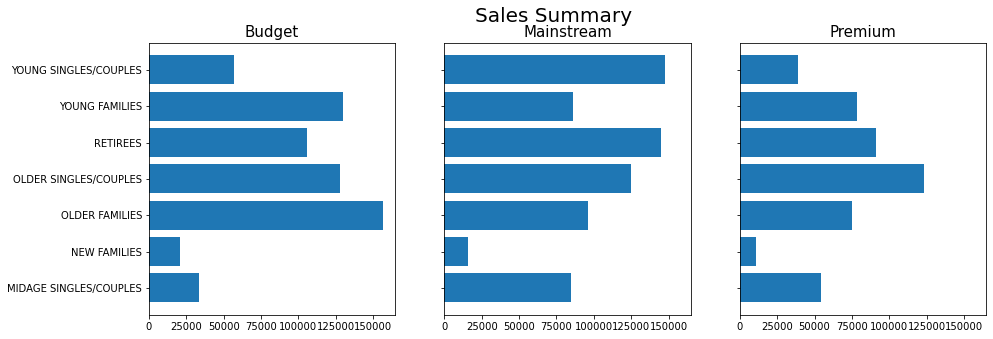

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axe = axes.ravel()
x1 = total_sale_summary.LIFESTAGE.iloc[:7]
y1 = total_sale_summary.TOT_SALES.iloc[:7]
axe[0].barh(y=x1, width=y1)
axe[0].set_title('Budget', fontsize=15)

x2 = total_sale_summary.LIFESTAGE.iloc[7:14]
y2 = total_sale_summary.TOT_SALES.iloc[7:14]
axe[1].barh(y=x2, width=y2)
axe[1].set_title('Mainstream', fontsize=15)

x3 = total_sale_summary.LIFESTAGE.iloc[14:21]
y3 = total_sale_summary.TOT_SALES.iloc[14:21]
axe[2].barh(y=x3, width=y3)
axe[2].set_title('Premium', fontsize=15)

fig.suptitle('Sales Summary', fontsize=20)


budget-older families, mainstream-young singles/couples and mainstream retirees are the main segments for chip sales

In [79]:
total_customer_summary = chips_data_merge.LYLTY_CARD_NBR.groupby([chips_data_merge.PREMIUM_CUSTOMER, chips_data_merge.LIFESTAGE]).count().reset_index()

Text(0.5, 0.98, 'Customer Summary')

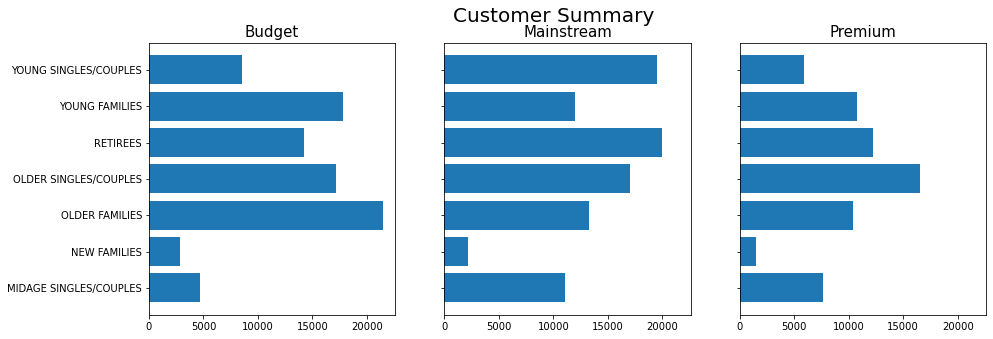

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axe = axes.ravel()
x1 = total_customer_summary.LIFESTAGE.iloc[:7]
y1 = total_customer_summary.LYLTY_CARD_NBR.iloc[:7]
axe[0].barh(y=x1, width=y1)
axe[0].set_title('Budget', fontsize=15)

x2 = total_customer_summary.LIFESTAGE.iloc[7:14]
y2 = total_customer_summary.LYLTY_CARD_NBR.iloc[7:14]
axe[1].barh(y=x2, width=y2)
axe[1].set_title('Mainstream', fontsize=15)

x3 = total_customer_summary.LIFESTAGE.iloc[14:21]
y3 = total_customer_summary.LYLTY_CARD_NBR.iloc[14:21]
axe[2].barh(y=x3, width=y3)
axe[2].set_title('Premium', fontsize=15)

fig.suptitle('Customer Summary', fontsize=20)

budget-older families, mainstream-young singles/couples and mainstream retirees are also the segments that buy chips the most. 

In [96]:
total_quantity_summary = chips_data_merge.PROD_QTY.groupby([chips_data_merge.PREMIUM_CUSTOMER, chips_data_merge.LIFESTAGE]).sum().reset_index()
average_units_per_customer = round(total_quantity_summary.PROD_QTY / total_customer_summary.LYLTY_CARD_NBR, 2)

Text(0.5, 0.98, 'Average Quantity Per Customer')

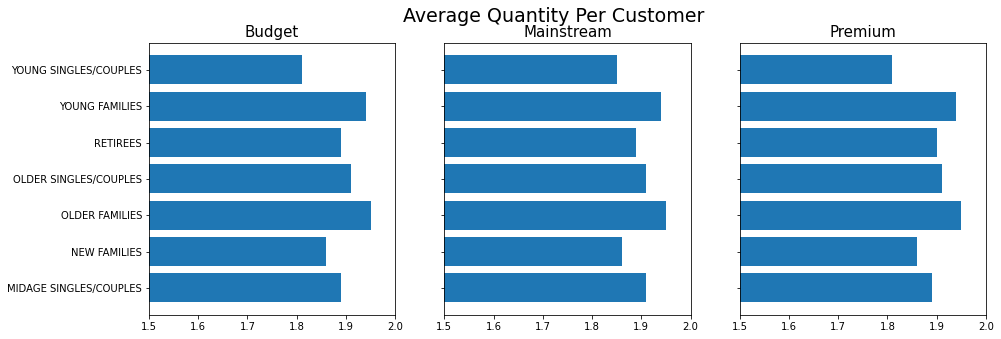

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axe = axes.ravel()
x1 = total_quantity_summary.LIFESTAGE.iloc[:7]
y1 = average_units_per_customer[:7]
axe[0].barh(y=x1, width=y1)
axe[0].set_title('Budget', fontsize=15)
axe[0].set_xlim(1.5, 2)

x2 = total_quantity_summary.LIFESTAGE.iloc[7:14]
y2 = average_units_per_customer[7:14]
axe[1].barh(y=x2, width=y2)
axe[1].set_title('Mainstream', fontsize=15)
axe[1].set_xlim(1.5, 2)

x3 = total_quantity_summary.LIFESTAGE.iloc[14:21]
y3 = average_units_per_customer[14:21]
axe[2].barh(y=x3, width=y3)
axe[2].set_title('Premium', fontsize=15)
axe[2].set_xlim(1.5, 2)

fig.suptitle('Average Quantity Per Customer', fontsize=19)


young families and older families tend to buy more chips than other people

In [100]:
average_price_per_unit = round(total_sale_summary.TOT_SALES / total_quantity_summary.PROD_QTY, 2)

Text(0.5, 0.98, 'Average Price Per Unit')

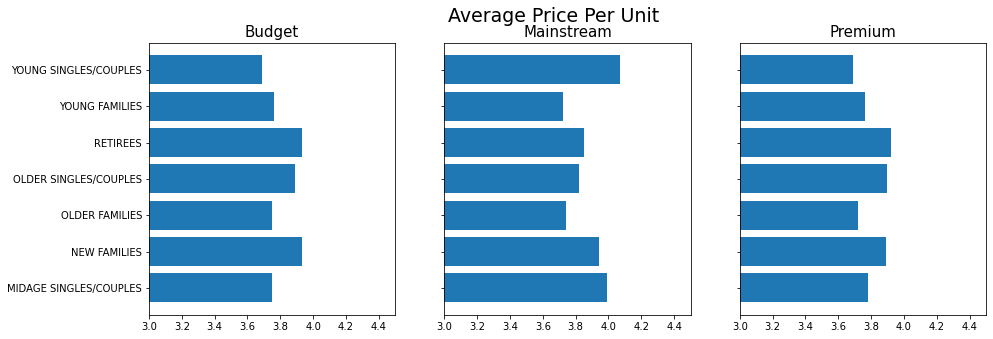

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axe = axes.ravel()
x1 = total_quantity_summary.LIFESTAGE.iloc[:7]
y1 = average_price_per_unit[:7]
axe[0].barh(y=x1, width=y1)
axe[0].set_title('Budget', fontsize=15)
axe[0].set_xlim(3, 4.5)

x2 = total_quantity_summary.LIFESTAGE.iloc[7:14]
y2 = average_price_per_unit[7:14]
axe[1].barh(y=x2, width=y2)
axe[1].set_title('Mainstream', fontsize=15)
axe[1].set_xlim(3, 4.5)

x3 = total_quantity_summary.LIFESTAGE.iloc[14:21]
y3 = average_price_per_unit[14:21]
axe[2].barh(y=x3, width=y3)
axe[2].set_title('Premium', fontsize=15)
axe[2].set_xlim(3, 4.5)

fig.suptitle('Average Price Per Unit', fontsize=19)


mainsteam young and midage singles/couples tend to buy more expensive chips. However, the differences in unit price is relatively small. Thus, we perform t-test to check whether the difference is significant.

#### T-test

In [5]:
# create dataset for each segment
chips_data_merge['average_price'] = round(chips_data_merge['TOT_SALES'] / chips_data_merge['PROD_QTY'], 2)
mainstream_young = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Mainstream') & (chips_data_merge.LIFESTAGE=='YOUNG SINGLES/COUPLES')]
mainstream_midage = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Mainstream') & (chips_data_merge.LIFESTAGE=='MIDAGE SINGLES/COUPLES')]
budget_young = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Budget') & (chips_data_merge.LIFESTAGE=='YOUNG SINGLES/COUPLES')]
budget_midage = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Budget') & (chips_data_merge.LIFESTAGE=='MIDAGE SINGLES/COUPLES')]
premium_young = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Premium') & (chips_data_merge.LIFESTAGE=='YOUNG SINGLES/COUPLES')]
premium_midage = chips_data_merge[(chips_data_merge.PREMIUM_CUSTOMER=='Premium') & (chips_data_merge.LIFESTAGE=='MIDAGE SINGLES/COUPLES')]

In [128]:
mainstream_midage.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,product_name,LIFESTAGE,PREMIUM_CUSTOMER,average_price
4692,2019-05-18,3,3159,1759,77,2,8.8,Doritos Corn Chips Nacho Cheese,MIDAGE SINGLES/COUPLES,Mainstream,4.4
4693,2019-05-16,3,3294,2370,51,2,8.8,Doritos Mexicana,MIDAGE SINGLES/COUPLES,Mainstream,4.4
4694,2018-08-18,4,4187,3492,89,2,10.8,Kettle Sweet Chilli And Sour Cream,MIDAGE SINGLES/COUPLES,Mainstream,5.4
4695,2019-05-19,4,4264,3841,47,2,8.8,Doritos Corn Chips Original,MIDAGE SINGLES/COUPLES,Mainstream,4.4
4696,2018-08-19,7,7036,6447,114,1,4.6,Kettle Sensations Siracha Lime,MIDAGE SINGLES/COUPLES,Mainstream,4.6


In [ ]:
# Shapiro-Wilk test for normality
stats.shapiro(mainstream_young['average_price'])
stats.shapiro(mainstream_midage['average_price'])
stats.shapiro(budget_young['average_price'])
stats.shapiro(budget_midage['average_price'])
stats.shapiro(premium_young['average_price'])
stats.shapiro(premium_young['average_price'])
# -> all p-value extremely small, none of the dataset is normally distributed

In [ ]:
# homogeneity check
stats.levene(mainstream_young['average_price'], budget_young['average_price'], premium_young['average_price'])
stats.levene(mainstream_midage['average_price'], budget_midage['average_price'], premium_young['average_price'])
# -> all p-value extremely small, there is homogeneity of variances 

In [ ]:
# t-test
stats.ttest_ind(mainstream_young['average_price'], budget_young['average_price'])
stats.ttest_ind(mainstream_young['average_price'], premium_young['average_price'])
stats.ttest_ind(mainstream_midage['average_price'], budget_midage['average_price'])
stats.ttest_ind(mainstream_midage['average_price'], premium_midage['average_price'])
# the unit price for mainstream young and midage singles and couples are significatnly higher than that of budget or premium.
# However, the datasets are not normally distributed and there is homogeneity of variances.

#### Analysis focus on mainstream young and mid-age singles and couples 

In [67]:
# prepare data
data = pd.read_csv('QVI_data.csv')
data = data[data['product_name'].str.contains('Salsa')==False]

# brands 
brands_mYoung = data['brand'][(data.PREMIUM_CUSTOMER=='Mainstream') & (data.LIFESTAGE=='YOUNG SINGLES/COUPLES')]
brands_mMidage = data['brand'][(data.PREMIUM_CUSTOMER=='Mainstream') & (data.LIFESTAGE=='MIDAGE SINGLES/COUPLES')]

# pack_sizes
packs_mYoung = data['pack_size'][(data.PREMIUM_CUSTOMER=='Mainstream') & (data.LIFESTAGE=='YOUNG SINGLES/COUPLES')]
packs_mMidage = data['pack_size'][(data.PREMIUM_CUSTOMER=='Mainstream') & (data.LIFESTAGE=='MIDAGE SINGLES/COUPLES')]


popular brands for young singles / couples

In [68]:
# convert string to list
brands_mYoung = brands_mYoung.apply(lambda x: [x])

# encoding
encode_ = mlxtend.preprocessing.TransactionEncoder()
encode_brandsY = encode_.fit_transform(brands_mYoung)

encode_df_brandsY = pd.DataFrame(encode_brandsY, columns=encode_.columns_)

# what is the most popular chip brand (support)
md=mlxtend.frequent_patterns.apriori(encode_df_brandsY)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df_brandsY,
                                           min_support=0.05, 
                                            use_colnames=True)
md_minsup.head(5)




,support,itemsets
0,0.106222,(Doritos)
1,0.196684,(Kettle)
2,0.118451,(Pringles)
3,0.098291,(Smiths)
4,0.059660,(Thins)


Doritos, Kettle, Pringles, Smiths, Thins are the top 5 popular brands for young singles/couples

popular brands for midage singles / couples

In [69]:
brands_mMidage = brands_mMidage.apply(lambda x: [x])

encode_ = mlxtend.preprocessing.TransactionEncoder()
encode_brandsM = encode_.fit_transform(brands_mMidage)

encode_df_brandsM = pd.DataFrame(encode_brandsM, columns=encode_.columns_)

md=mlxtend.frequent_patterns.apriori(encode_df_brandsM)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df_brandsM,
                                           min_support=0.05, 
                                            use_colnames=True)
md_minsup.head(5)

,support,itemsets
0,0.096620,(Doritos)
1,0.192519,(Kettle)
2,0.104461,(Pringles)
3,0.055070,(RRD)
4,0.115007,(Smiths)


instead of Thins, RRD is oneof the 5 popular brands for midage singles / couples.

popular pack size for young singles / couples

In [70]:
packs_mYoung = packs_mYoung.apply(lambda x: [x])

encode_ = mlxtend.preprocessing.TransactionEncoder()
encode_packsM = encode_.fit_transform(packs_mYoung)

encode_df_packsY = pd.DataFrame(encode_packsY, columns=encode_.columns_)

# what is the most popular chip brand (support)
md=mlxtend.frequent_patterns.apriori(encode_df_packsY)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df_packsY,
                                           min_support=0.05, 
                                            use_colnames=True)
md_minsup.head(5)


,support,itemsets
0,0.104943,(110)
1,0.118451,(134)
2,0.157593,(150)
3,0.056386,(165)
4,0.080587,(170)


popular pack size for midage singles / couples

In [71]:
packs_mMidage = packs_mMidage.apply(lambda x: [x])

encode_ = mlxtend.preprocessing.TransactionEncoder()
encode_packsM = encode_.fit_transform(packs_mMidage)

encode_df_packsM = pd.DataFrame(encode_packsM, columns=encode_.columns_)

# what is the most popular chip brand (support)
md=mlxtend.frequent_patterns.apriori(encode_df_packsM)
md_minsup=mlxtend.frequent_patterns.apriori(encode_df_packsM,
                                           min_support=0.05, 
                                            use_colnames=True)
md_minsup.head(5)

,support,itemsets
0,0.101307,(110)
1,0.104461,(134)
2,0.160162,(150)
3,0.057774,(165)
4,0.079495,(170)


 110g is the most popular pack size for both age groups.